### gather and format data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.contrib.tensor_forest.python import tensor_forest
from tensorflow.python.ops import resources
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import h5py

df = pd.read_csv('sensors_1.csv')
df.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow = pd.read_csv('Flow_1.csv')
flow.columns = ['Flow']

df.head()

/Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds
0,0.440000,0.432000,0.456000,0.497778,0.000000,0.000000,0.000000,0.000000,15.0,4.0,34.451422
1,0.440000,0.436000,0.460000,0.497778,0.000000,0.195197,0.195197,0.000000,15.0,4.0,34.461668
2,0.434667,0.431979,0.461340,0.500741,-0.163603,-0.042012,0.165049,0.090891,15.0,4.0,34.472535
3,0.431968,0.429958,0.459996,0.499995,-0.192717,-0.100917,0.074816,0.042338,15.0,4.0,34.483387
4,0.431975,0.427120,0.460805,0.499548,-0.139941,-0.153101,0.074830,0.020195,15.0,4.0,34.494189


In [2]:
flow.head()

,Flow
0,23.876163
1,25.924320
2,24.970956
3,24.909395
4,24.410650


In [3]:
def movingAvg(Class, windowSize):
    """
    Create moving average to remove single outliers

    Args:
        Class (list): List of inhale / exhale classes
        Windowsize (int): Size of moving average window

    Returns:
        filteredClass (list): Filtered list of classes
    """
    
    filteredClass = []
    for i in range(0, len(Class)):

        if i < windowSize - 1:
            filteredClass.append(Class[i])

        elif Class[i] != Class[i - 1]:
            if sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize > 1:
                filteredClass.append(2)

            elif sum(Class[i - (windowSize - 1):(i + 1)]) / windowSize < 1:
                filteredClass.append(0)

            else:
                filteredClass.append(Class[i])

        elif Class[i] == Class[i - 1]:
            filteredClass.append(Class[i])
            
    return filteredClass

def classSwitch(Class):
    """
    Class switch function to filter 3 classifiers down to 2 (inhale and exhale)

    Args:
        Class (list): List of inhale / exhale classes

    Returns:
        decisionClass (list): Filtered (with moving average) of resulting simplified class
    """

    decision = []
    for i in range(0, len(Class)):
        
        if Class[i] == 1:
            decision.append(1)
            
        elif Class[i] == 0:
            decision.append(0)
            
        elif Class[i] == 2:
            if len(decision) > 1:
                decision.append(decision[-1])
            else:
                decision.append(2)
            
    return movingAvg(decision, 3)

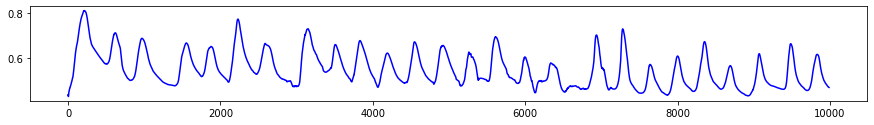

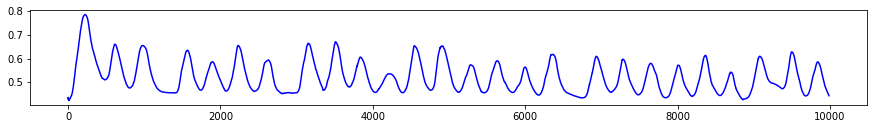

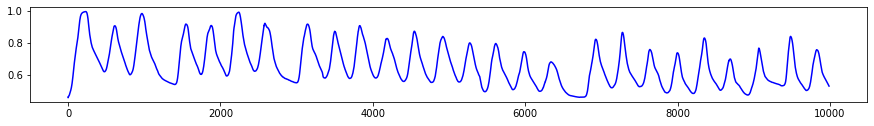

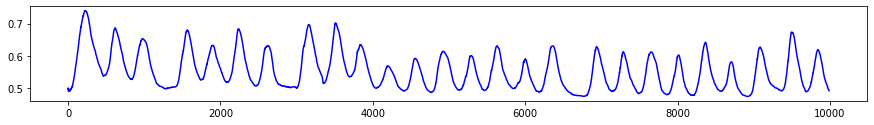

In [37]:
x = range(0, len(df))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df['4'], 'b')
plt.show()

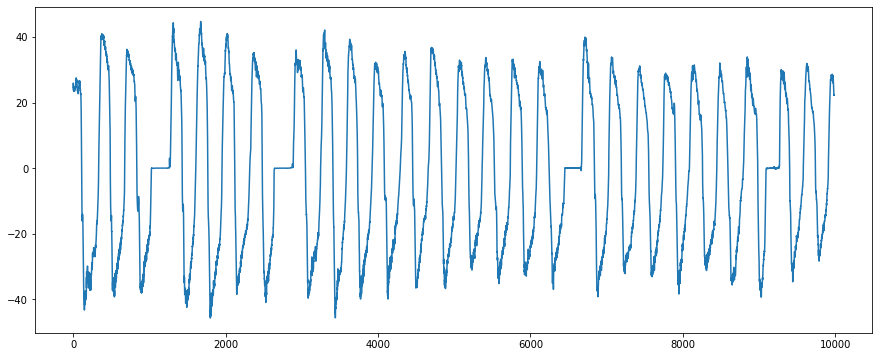

In [5]:
fig = plt.figure(figsize = (15, 6))
plt.plot(flow['Flow'])

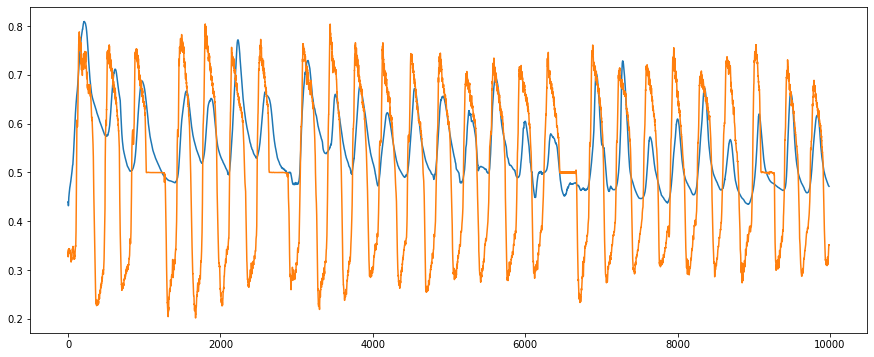

In [6]:
flow['a'] = (flow['Flow'] / 150) - 0.5
fig = plt.figure(figsize = (15, 6))
plt.plot(x, df['1'], x, flow['a']*-1)

In [7]:
flow.drop('a', inplace = True, axis = 1)

In [8]:
def label_fix(label):
    if label < -25:
        return 0
    elif label > 25:
        return 1
    else:
        return 2

df['Class'] = flow['Flow'].apply(label_fix)

In [9]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.440000,0.432000,0.456000,0.497778,0.000000,0.000000,0.000000,0.000000,15.0,4.0,34.451422,2
1,0.440000,0.436000,0.460000,0.497778,0.000000,0.195197,0.195197,0.000000,15.0,4.0,34.461668,1
2,0.434667,0.431979,0.461340,0.500741,-0.163603,-0.042012,0.165049,0.090891,15.0,4.0,34.472535,2
3,0.431968,0.429958,0.459996,0.499995,-0.192717,-0.100917,0.074816,0.042338,15.0,4.0,34.483387,2
4,0.431975,0.427120,0.460805,0.499548,-0.139941,-0.153101,0.074830,0.020195,15.0,4.0,34.494189,2


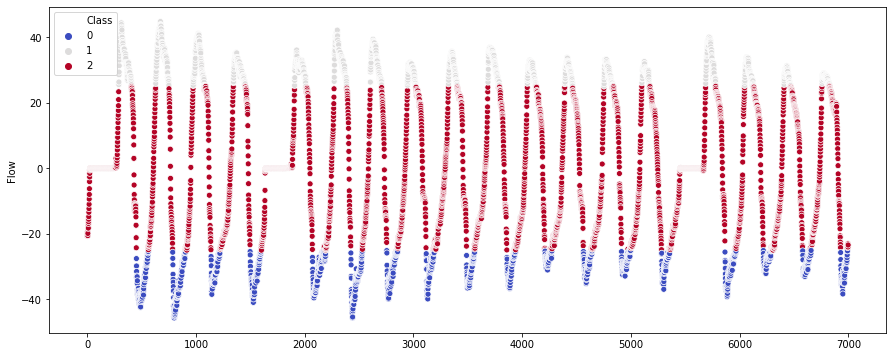

In [10]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = flow['Flow'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

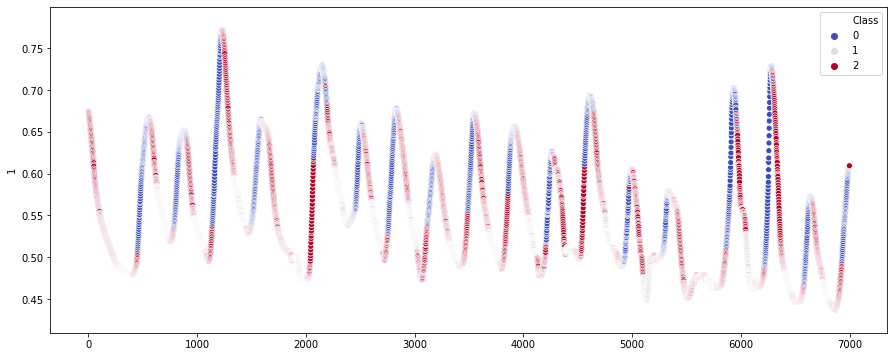

In [11]:
fig = plt.figure(figsize = (15, 6))
sns.scatterplot(y = df['1'][1000:8000], x = range(0, 7000), hue = df['Class'][1000:8000], palette = 'coolwarm')

In [12]:
df.head()

,1,2,3,4,d1,d2,d3,d4,hours,minutes,seconds,Class
0,0.440000,0.432000,0.456000,0.497778,0.000000,0.000000,0.000000,0.000000,15.0,4.0,34.451422,2
1,0.440000,0.436000,0.460000,0.497778,0.000000,0.195197,0.195197,0.000000,15.0,4.0,34.461668,1
2,0.434667,0.431979,0.461340,0.500741,-0.163603,-0.042012,0.165049,0.090891,15.0,4.0,34.472535,2
3,0.431968,0.429958,0.459996,0.499995,-0.192717,-0.100917,0.074816,0.042338,15.0,4.0,34.483387,2
4,0.431975,0.427120,0.460805,0.499548,-0.139941,-0.153101,0.074830,0.020195,15.0,4.0,34.494189,2


In [13]:
# Create the data matrix
X = df.drop('Class', axis = 1)
X.drop('hours', inplace = True, axis = 1)
X.drop('minutes', inplace = True, axis = 1)
X.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
y = df['Class']
y = pd.DataFrame(y, index = None, columns = ['Class'])

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
y_test.reset_index(inplace = True, drop = True)
y_train.reset_index(inplace = True, drop = True)

### model training - deep learning

In [14]:
# Develop keras sequential model with optimized parameters through grid search cv
model = keras.Sequential()
model.add(keras.layers.Dense(150, activation = tf.nn.relu, input_dim = 8))
model.add(keras.layers.Dropout(0.3))
#model.add(keras.layers.Dense(125, activation = tf.nn.relu))
#model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(100, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(50, activation = tf.nn.relu))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(3, activation = tf.nn.softmax))

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

W1108 10:53:27.626888 4753079744 deprecation.py:506] From /Users/mikefurr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               1350      
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1

In [15]:
EPOCHS = 5000
model.fit(X_train, y_train, epochs = EPOCHS)

Epoch 1/5000
6992/6992 [==============================] - 0s 43us/sample - loss: 0.7946 - acc: 0.6340
Epoch 2/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.6566 - acc: 0.6856
Epoch 3/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.6055 - acc: 0.6944
Epoch 4/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.5813 - acc: 0.7054
Epoch 5/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.5692 - acc: 0.7154
Epoch 6/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.5582 - acc: 0.7168
Epoch 7/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.5484 - acc: 0.7347
Epoch 8/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.5381 - acc: 0.7457
Epoch 9/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.5231 - acc: 0.7501
Epoch 10/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 

6992/6992 [==============================] - 0s 27us/sample - loss: 0.3806 - acc: 0.8219
Epoch 81/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.3778 - acc: 0.8267
Epoch 82/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3848 - acc: 0.8221
Epoch 83/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3739 - acc: 0.8308
Epoch 84/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3781 - acc: 0.8291
Epoch 85/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3824 - acc: 0.8198
Epoch 86/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3823 - acc: 0.8271
Epoch 87/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3845 - acc: 0.8277
Epoch 88/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3748 - acc: 0.8247
Epoch 89/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.377

6992/6992 [==============================] - 0s 26us/sample - loss: 0.3574 - acc: 0.8400
Epoch 160/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.3470 - acc: 0.8470
Epoch 161/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3376 - acc: 0.8518
Epoch 162/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.3358 - acc: 0.8500
Epoch 163/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3372 - acc: 0.8510
Epoch 164/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3457 - acc: 0.8420
Epoch 165/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.3361 - acc: 0.8495
Epoch 166/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3496 - acc: 0.8495
Epoch 167/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.3402 - acc: 0.8491
Epoch 168/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 27us/sample - loss: 0.3167 - acc: 0.8624
Epoch 238/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.3081 - acc: 0.8654
Epoch 239/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.3091 - acc: 0.8637
Epoch 240/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3178 - acc: 0.8616
Epoch 241/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.3172 - acc: 0.8604
Epoch 242/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3178 - acc: 0.8587
Epoch 243/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3230 - acc: 0.8583
Epoch 244/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.3105 - acc: 0.8643
Epoch 245/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3163 - acc: 0.8577
Epoch 246/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 25us/sample - loss: 0.3131 - acc: 0.8626
Epoch 316/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.3085 - acc: 0.8667
Epoch 317/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2945 - acc: 0.8724
Epoch 318/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3056 - acc: 0.8667
Epoch 319/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3102 - acc: 0.8623
Epoch 320/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2913 - acc: 0.8741
Epoch 321/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2924 - acc: 0.8729
Epoch 322/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3061 - acc: 0.8647
Epoch 323/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2979 - acc: 0.8707
Epoch 324/5000
6992/6992 [==============================] - 0s 28us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2815 - acc: 0.8776
Epoch 394/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2839 - acc: 0.8743
Epoch 395/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.3016 - acc: 0.8716
Epoch 396/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2783 - acc: 0.8764
Epoch 397/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2934 - acc: 0.8716
Epoch 398/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2896 - acc: 0.8789
Epoch 399/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2850 - acc: 0.8799
Epoch 400/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2796 - acc: 0.8767
Epoch 401/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2904 - acc: 0.8784
Epoch 402/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2657 - acc: 0.8843
Epoch 472/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2739 - acc: 0.8830
Epoch 473/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2699 - acc: 0.8842
Epoch 474/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2717 - acc: 0.8829
Epoch 475/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2823 - acc: 0.8796
Epoch 476/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2704 - acc: 0.8840
Epoch 477/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2702 - acc: 0.8846
Epoch 478/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2699 - acc: 0.8826
Epoch 479/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2810 - acc: 0.8776
Epoch 480/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 34us/sample - loss: 0.2726 - acc: 0.8813
Epoch 550/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.2661 - acc: 0.8896
Epoch 551/5000
6992/6992 [==============================] - 0s 35us/sample - loss: 0.2636 - acc: 0.8914
Epoch 552/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.2590 - acc: 0.8859
Epoch 553/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.2693 - acc: 0.8862
Epoch 554/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.2608 - acc: 0.8877
Epoch 555/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2642 - acc: 0.8894
Epoch 556/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2650 - acc: 0.8867
Epoch 557/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2709 - acc: 0.8822
Epoch 558/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2575 - acc: 0.8920
Epoch 628/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2446 - acc: 0.8960
Epoch 629/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2568 - acc: 0.8933
Epoch 630/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2711 - acc: 0.8829
Epoch 631/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2661 - acc: 0.8873
Epoch 632/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2692 - acc: 0.8867
Epoch 633/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2603 - acc: 0.8902
Epoch 634/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2558 - acc: 0.8897
Epoch 635/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2622 - acc: 0.8907
Epoch 636/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2424 - acc: 0.8966
Epoch 706/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2570 - acc: 0.8934
Epoch 707/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2507 - acc: 0.8973
Epoch 708/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2586 - acc: 0.8873
Epoch 709/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2463 - acc: 0.8955
Epoch 710/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2494 - acc: 0.8962
Epoch 711/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2439 - acc: 0.8970
Epoch 712/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2610 - acc: 0.8903
Epoch 713/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2589 - acc: 0.8874
Epoch 714/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 27us/sample - loss: 0.2441 - acc: 0.8967
Epoch 784/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2507 - acc: 0.8963
Epoch 785/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2469 - acc: 0.8940
Epoch 786/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2554 - acc: 0.8913
Epoch 787/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2530 - acc: 0.8930
Epoch 788/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2646 - acc: 0.8849
Epoch 789/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2571 - acc: 0.8913
Epoch 790/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2558 - acc: 0.8909
Epoch 791/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2443 - acc: 0.8953
Epoch 792/5000
6992/6992 [==============================] - 0s 27us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2383 - acc: 0.9009
Epoch 862/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2432 - acc: 0.8976
Epoch 863/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2405 - acc: 0.9000
Epoch 864/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2516 - acc: 0.8927
Epoch 865/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2484 - acc: 0.8955
Epoch 866/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2510 - acc: 0.8879
Epoch 867/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2336 - acc: 0.8999
Epoch 868/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2487 - acc: 0.8942
Epoch 869/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2399 - acc: 0.8957
Epoch 870/5000
6992/6992 [==============================] - 0s 31us/sample - lo

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2366 - acc: 0.9003
Epoch 940/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2368 - acc: 0.8999
Epoch 941/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2413 - acc: 0.8977
Epoch 942/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2352 - acc: 0.9029
Epoch 943/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2441 - acc: 0.8979
Epoch 944/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2404 - acc: 0.8986
Epoch 945/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2337 - acc: 0.8997
Epoch 946/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2343 - acc: 0.8992
Epoch 947/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2268 - acc: 0.9042
Epoch 948/5000
6992/6992 [==============================] - 0s 26us/sample - lo

6992/6992 [==============================] - 0s 25us/sample - loss: 0.2277 - acc: 0.9035
Epoch 1018/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2304 - acc: 0.8992
Epoch 1019/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2347 - acc: 0.9025
Epoch 1020/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2471 - acc: 0.8950
Epoch 1021/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2391 - acc: 0.8975
Epoch 1022/5000
6992/6992 [==============================] - 0s 36us/sample - loss: 0.2329 - acc: 0.9000
Epoch 1023/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2378 - acc: 0.8997
Epoch 1024/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2302 - acc: 0.9047
Epoch 1025/5000
6992/6992 [==============================] - 0s 35us/sample - loss: 0.2318 - acc: 0.9025
Epoch 1026/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.2250 - acc: 0.9035
Epoch 1096/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2454 - acc: 0.9006
Epoch 1097/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2373 - acc: 0.9036
Epoch 1098/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2432 - acc: 0.8993
Epoch 1099/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2330 - acc: 0.9029
Epoch 1100/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2399 - acc: 0.9025
Epoch 1101/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2315 - acc: 0.8997
Epoch 1102/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2298 - acc: 0.9023
Epoch 1103/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2393 - acc: 0.9003
Epoch 1104/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 29us/sample - loss: 0.2208 - acc: 0.9085
Epoch 1174/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2241 - acc: 0.9049
Epoch 1175/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2249 - acc: 0.9056
Epoch 1176/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2283 - acc: 0.9017
Epoch 1177/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2226 - acc: 0.9065
Epoch 1178/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2155 - acc: 0.9088
Epoch 1179/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2277 - acc: 0.9047
Epoch 1180/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2285 - acc: 0.9033
Epoch 1181/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2257 - acc: 0.9075
Epoch 1182/5000
6992/6992 [==============================] - 0s 28us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.2209 - acc: 0.9080
Epoch 1252/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2231 - acc: 0.9075
Epoch 1253/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2257 - acc: 0.9049
Epoch 1254/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2147 - acc: 0.9126
Epoch 1255/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2294 - acc: 0.9053
Epoch 1256/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2255 - acc: 0.8992
Epoch 1257/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.2302 - acc: 0.9085
Epoch 1258/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2173 - acc: 0.9079
Epoch 1259/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2381 - acc: 0.9030
Epoch 1260/5000
6992/6992 [==============================] - 0s 28us/sa

6992/6992 [==============================] - 0s 30us/sample - loss: 0.2192 - acc: 0.9078
Epoch 1330/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.2227 - acc: 0.9085
Epoch 1331/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2338 - acc: 0.9016
Epoch 1332/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2231 - acc: 0.9035
Epoch 1333/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2246 - acc: 0.9078
Epoch 1334/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2162 - acc: 0.9073
Epoch 1335/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2169 - acc: 0.9109
Epoch 1336/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2320 - acc: 0.9027
Epoch 1337/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2293 - acc: 0.9039
Epoch 1338/5000
6992/6992 [==============================] - 0s 30us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2190 - acc: 0.9076
Epoch 1408/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2164 - acc: 0.9113
Epoch 1409/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2164 - acc: 0.9110
Epoch 1410/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2131 - acc: 0.9113
Epoch 1411/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2213 - acc: 0.9050
Epoch 1412/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2211 - acc: 0.9073
Epoch 1413/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2164 - acc: 0.9118
Epoch 1414/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2300 - acc: 0.9013
Epoch 1415/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2197 - acc: 0.9073
Epoch 1416/5000
6992/6992 [==============================] - 0s 28us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2192 - acc: 0.9102
Epoch 1486/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2219 - acc: 0.9090
Epoch 1487/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2249 - acc: 0.9042
Epoch 1488/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2111 - acc: 0.9176
Epoch 1489/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2041 - acc: 0.9145
Epoch 1490/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2180 - acc: 0.9136
Epoch 1491/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2350 - acc: 0.9042
Epoch 1492/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2251 - acc: 0.9109
Epoch 1493/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2176 - acc: 0.9078
Epoch 1494/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1996 - acc: 0.9156
Epoch 1564/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2151 - acc: 0.9112
Epoch 1565/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2193 - acc: 0.9086
Epoch 1566/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2136 - acc: 0.9108
Epoch 1567/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2286 - acc: 0.8999
Epoch 1568/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2182 - acc: 0.9093
Epoch 1569/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2088 - acc: 0.9145
Epoch 1570/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2066 - acc: 0.9166
Epoch 1571/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2110 - acc: 0.9113
Epoch 1572/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2128 - acc: 0.9133
Epoch 1642/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2126 - acc: 0.9119
Epoch 1643/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2114 - acc: 0.9136
Epoch 1644/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2161 - acc: 0.9082
Epoch 1645/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2191 - acc: 0.9128
Epoch 1646/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2044 - acc: 0.9148
Epoch 1647/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2137 - acc: 0.9125
Epoch 1648/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2141 - acc: 0.9079
Epoch 1649/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1996 - acc: 0.9196
Epoch 1650/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2155 - acc: 0.9153
Epoch 1720/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2114 - acc: 0.9143
Epoch 1721/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2123 - acc: 0.9126
Epoch 1722/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2051 - acc: 0.9166
Epoch 1723/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2159 - acc: 0.9100
Epoch 1724/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2031 - acc: 0.9169
Epoch 1725/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2142 - acc: 0.9095
Epoch 1726/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2153 - acc: 0.9098
Epoch 1727/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2224 - acc: 0.9118
Epoch 1728/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.2105 - acc: 0.9106
Epoch 1798/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2002 - acc: 0.9158
Epoch 1799/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2056 - acc: 0.9173
Epoch 1800/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2130 - acc: 0.9122
Epoch 1801/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2213 - acc: 0.9113
Epoch 1802/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2213 - acc: 0.9068
Epoch 1803/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2288 - acc: 0.9089
Epoch 1804/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.2166 - acc: 0.9146
Epoch 1805/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1985 - acc: 0.9183
Epoch 1806/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.2253 - acc: 0.9088
Epoch 1876/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2094 - acc: 0.9142
Epoch 1877/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2111 - acc: 0.9123
Epoch 1878/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2085 - acc: 0.9125
Epoch 1879/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2061 - acc: 0.9156
Epoch 1880/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1974 - acc: 0.9159
Epoch 1881/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2024 - acc: 0.9191
Epoch 1882/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2113 - acc: 0.9120
Epoch 1883/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2110 - acc: 0.9152
Epoch 1884/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1893 - acc: 0.9213
Epoch 1954/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2036 - acc: 0.9172
Epoch 1955/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2093 - acc: 0.9139
Epoch 1956/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2009 - acc: 0.9162
Epoch 1957/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1992 - acc: 0.9202
Epoch 1958/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1976 - acc: 0.9180
Epoch 1959/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2117 - acc: 0.9129
Epoch 1960/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2021 - acc: 0.9215
Epoch 1961/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2172 - acc: 0.9115
Epoch 1962/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.1984 - acc: 0.9166
Epoch 2032/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2160 - acc: 0.9080
Epoch 2033/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.2170 - acc: 0.9119
Epoch 2034/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2054 - acc: 0.9116
Epoch 2035/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2078 - acc: 0.9163
Epoch 2036/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2012 - acc: 0.9158
Epoch 2037/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1974 - acc: 0.9166
Epoch 2038/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1924 - acc: 0.9218
Epoch 2039/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1965 - acc: 0.9185
Epoch 2040/5000
6992/6992 [==============================] - 0s 25us/sa

6992/6992 [==============================] - 0s 29us/sample - loss: 0.2038 - acc: 0.9159
Epoch 2110/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1997 - acc: 0.9118
Epoch 2111/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2001 - acc: 0.9125
Epoch 2112/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.1939 - acc: 0.9192
Epoch 2113/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2065 - acc: 0.9125
Epoch 2114/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1980 - acc: 0.9205
Epoch 2115/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1935 - acc: 0.9196
Epoch 2116/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1976 - acc: 0.9211
Epoch 2117/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1963 - acc: 0.9223
Epoch 2118/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 28us/sample - loss: 0.1869 - acc: 0.9231
Epoch 2188/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.2039 - acc: 0.9176
Epoch 2189/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2088 - acc: 0.9149
Epoch 2190/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2081 - acc: 0.9150
Epoch 2191/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2020 - acc: 0.9166
Epoch 2192/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1946 - acc: 0.9182
Epoch 2193/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1946 - acc: 0.9208
Epoch 2194/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1962 - acc: 0.9188
Epoch 2195/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1942 - acc: 0.9203
Epoch 2196/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1946 - acc: 0.9186
Epoch 2266/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.2059 - acc: 0.9159
Epoch 2267/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.2088 - acc: 0.9165
Epoch 2268/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.1982 - acc: 0.9160
Epoch 2269/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1993 - acc: 0.9169
Epoch 2270/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1973 - acc: 0.9235
Epoch 2271/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.2005 - acc: 0.9183
Epoch 2272/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1897 - acc: 0.9213
Epoch 2273/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1966 - acc: 0.9218
Epoch 2274/5000
6992/6992 [==============================] - 0s 28us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1980 - acc: 0.9176
Epoch 2344/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1893 - acc: 0.9233
Epoch 2345/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1919 - acc: 0.9251
Epoch 2346/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2035 - acc: 0.9152
Epoch 2347/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1934 - acc: 0.9212
Epoch 2348/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1843 - acc: 0.9272
Epoch 2349/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1951 - acc: 0.9178
Epoch 2350/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1868 - acc: 0.9255
Epoch 2351/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2014 - acc: 0.9176
Epoch 2352/5000
6992/6992 [==============================] - 0s 25us/sa

6992/6992 [==============================] - 0s 29us/sample - loss: 0.2009 - acc: 0.9153
Epoch 2422/5000
6992/6992 [==============================] - 0s 32us/sample - loss: 0.1976 - acc: 0.9193
Epoch 2423/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.1871 - acc: 0.9261
Epoch 2424/5000
6992/6992 [==============================] - 0s 42us/sample - loss: 0.2023 - acc: 0.9169
Epoch 2425/5000
6992/6992 [==============================] - 0s 34us/sample - loss: 0.1953 - acc: 0.9189
Epoch 2426/5000
6992/6992 [==============================] - 0s 33us/sample - loss: 0.1984 - acc: 0.9216
Epoch 2427/5000
6992/6992 [==============================] - 0s 36us/sample - loss: 0.2040 - acc: 0.9192
Epoch 2428/5000
6992/6992 [==============================] - 0s 36us/sample - loss: 0.1908 - acc: 0.9212
Epoch 2429/5000
6992/6992 [==============================] - 0s 36us/sample - loss: 0.1970 - acc: 0.9168
Epoch 2430/5000
6992/6992 [==============================] - 0s 36us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1945 - acc: 0.9195
Epoch 2500/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1990 - acc: 0.9199
Epoch 2501/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1929 - acc: 0.9222
Epoch 2502/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1919 - acc: 0.9203
Epoch 2503/5000
6992/6992 [==============================] - 0s 33us/sample - loss: 0.1916 - acc: 0.9268
Epoch 2504/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.2096 - acc: 0.9160
Epoch 2505/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1975 - acc: 0.9156
Epoch 2506/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1960 - acc: 0.9196
Epoch 2507/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1966 - acc: 0.9201
Epoch 2508/5000
6992/6992 [==============================] - 0s 25us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1945 - acc: 0.9201
Epoch 2578/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1963 - acc: 0.9219
Epoch 2579/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1827 - acc: 0.9232
Epoch 2580/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2011 - acc: 0.9218
Epoch 2581/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1903 - acc: 0.9223
Epoch 2582/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2059 - acc: 0.9173
Epoch 2583/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1892 - acc: 0.9252
Epoch 2584/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1939 - acc: 0.9216
Epoch 2585/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1866 - acc: 0.9261
Epoch 2586/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1975 - acc: 0.9173
Epoch 2656/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1988 - acc: 0.9169
Epoch 2657/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1819 - acc: 0.9241
Epoch 2658/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1933 - acc: 0.9255
Epoch 2659/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1904 - acc: 0.9232
Epoch 2660/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2018 - acc: 0.9183
Epoch 2661/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1909 - acc: 0.9216
Epoch 2662/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1983 - acc: 0.9189
Epoch 2663/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.1915 - acc: 0.9213
Epoch 2664/5000
6992/6992 [==============================] - 0s 42us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1871 - acc: 0.9216
Epoch 2734/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1921 - acc: 0.9251
Epoch 2735/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1963 - acc: 0.9209
Epoch 2736/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.2030 - acc: 0.9163
Epoch 2737/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1924 - acc: 0.9245
Epoch 2738/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1904 - acc: 0.9248
Epoch 2739/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1927 - acc: 0.9229
Epoch 2740/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1939 - acc: 0.9192
Epoch 2741/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1945 - acc: 0.9225
Epoch 2742/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1789 - acc: 0.9281
Epoch 2812/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.1909 - acc: 0.9243
Epoch 2813/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1908 - acc: 0.9249
Epoch 2814/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1884 - acc: 0.9253
Epoch 2815/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1957 - acc: 0.9162
Epoch 2816/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1866 - acc: 0.9263
Epoch 2817/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1941 - acc: 0.9203
Epoch 2818/5000
6992/6992 [==============================] - 0s 34us/sample - loss: 0.1858 - acc: 0.9229
Epoch 2819/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1830 - acc: 0.9262
Epoch 2820/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1894 - acc: 0.9239
Epoch 2890/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1905 - acc: 0.9263
Epoch 2891/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1807 - acc: 0.9321
Epoch 2892/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1864 - acc: 0.9266
Epoch 2893/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.2007 - acc: 0.9222
Epoch 2894/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1988 - acc: 0.9205
Epoch 2895/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1873 - acc: 0.9236
Epoch 2896/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1777 - acc: 0.9255
Epoch 2897/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1841 - acc: 0.9245
Epoch 2898/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.2038 - acc: 0.9183
Epoch 2968/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1909 - acc: 0.9258
Epoch 2969/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1851 - acc: 0.9261
Epoch 2970/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1911 - acc: 0.9249
Epoch 2971/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1838 - acc: 0.9255
Epoch 2972/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1916 - acc: 0.9255
Epoch 2973/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1853 - acc: 0.9259
Epoch 2974/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1936 - acc: 0.9222
Epoch 2975/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1875 - acc: 0.9252
Epoch 2976/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.1856 - acc: 0.9265
Epoch 3046/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1851 - acc: 0.9248
Epoch 3047/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1905 - acc: 0.9242
Epoch 3048/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1874 - acc: 0.9239
Epoch 3049/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1866 - acc: 0.9238
Epoch 3050/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1847 - acc: 0.9248
Epoch 3051/5000
6992/6992 [==============================] - 0s 32us/sample - loss: 0.1893 - acc: 0.9216
Epoch 3052/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.1941 - acc: 0.9252
Epoch 3053/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1868 - acc: 0.9248
Epoch 3054/5000
6992/6992 [==============================] - 0s 32us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1888 - acc: 0.9228
Epoch 3124/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1837 - acc: 0.9258
Epoch 3125/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1891 - acc: 0.9231
Epoch 3126/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1838 - acc: 0.9241
Epoch 3127/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1980 - acc: 0.9208
Epoch 3128/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1824 - acc: 0.9259
Epoch 3129/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1869 - acc: 0.9242
Epoch 3130/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1980 - acc: 0.9191
Epoch 3131/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1790 - acc: 0.9289
Epoch 3132/5000
6992/6992 [==============================] - 0s 25us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1887 - acc: 0.9236
Epoch 3202/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1762 - acc: 0.9316
Epoch 3203/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1867 - acc: 0.9281
Epoch 3204/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1782 - acc: 0.9271
Epoch 3205/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1824 - acc: 0.9276
Epoch 3206/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1722 - acc: 0.9278
Epoch 3207/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1959 - acc: 0.9211
Epoch 3208/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1985 - acc: 0.9170
Epoch 3209/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1867 - acc: 0.9231
Epoch 3210/5000
6992/6992 [==============================] - 0s 25us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.1945 - acc: 0.9209
Epoch 3280/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1886 - acc: 0.9219
Epoch 3281/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1898 - acc: 0.9236
Epoch 3282/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1947 - acc: 0.9203
Epoch 3283/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1876 - acc: 0.9252
Epoch 3284/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1848 - acc: 0.9263
Epoch 3285/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1773 - acc: 0.9282
Epoch 3286/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1985 - acc: 0.9226
Epoch 3287/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1887 - acc: 0.9233
Epoch 3288/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 25us/sample - loss: 0.1867 - acc: 0.9251
Epoch 3358/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1801 - acc: 0.9245
Epoch 3359/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1844 - acc: 0.9266
Epoch 3360/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1926 - acc: 0.9216
Epoch 3361/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1817 - acc: 0.9253
Epoch 3362/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1641 - acc: 0.9341
Epoch 3363/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1922 - acc: 0.9256
Epoch 3364/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1844 - acc: 0.9253
Epoch 3365/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1848 - acc: 0.9255
Epoch 3366/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1826 - acc: 0.9259
Epoch 3436/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1893 - acc: 0.9225
Epoch 3437/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1855 - acc: 0.9286
Epoch 3438/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1977 - acc: 0.9226
Epoch 3439/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1859 - acc: 0.9248
Epoch 3440/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1995 - acc: 0.9219
Epoch 3441/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1891 - acc: 0.9232
Epoch 3442/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1821 - acc: 0.9283
Epoch 3443/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1809 - acc: 0.9263
Epoch 3444/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 33us/sample - loss: 0.1844 - acc: 0.9255
Epoch 3514/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1839 - acc: 0.9265
Epoch 3515/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1932 - acc: 0.9279
Epoch 3516/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1717 - acc: 0.9318
Epoch 3517/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1813 - acc: 0.9279
Epoch 3518/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1904 - acc: 0.9239
Epoch 3519/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1850 - acc: 0.9282
Epoch 3520/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1862 - acc: 0.9251
Epoch 3521/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1755 - acc: 0.9305
Epoch 3522/5000
6992/6992 [==============================] - 0s 30us/sa

6992/6992 [==============================] - 0s 35us/sample - loss: 0.1859 - acc: 0.9226
Epoch 3592/5000
6992/6992 [==============================] - 0s 34us/sample - loss: 0.1773 - acc: 0.9256
Epoch 3593/5000
6992/6992 [==============================] - 0s 33us/sample - loss: 0.1813 - acc: 0.9259
Epoch 3594/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1940 - acc: 0.9229
Epoch 3595/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.1829 - acc: 0.9271
Epoch 3596/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.1666 - acc: 0.9312
Epoch 3597/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1858 - acc: 0.9282
Epoch 3598/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1826 - acc: 0.9314
Epoch 3599/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1846 - acc: 0.9278
Epoch 3600/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1981 - acc: 0.9216
Epoch 3670/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1833 - acc: 0.9283
Epoch 3671/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1773 - acc: 0.9265
Epoch 3672/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1759 - acc: 0.9255
Epoch 3673/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1861 - acc: 0.9285
Epoch 3674/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1904 - acc: 0.9243
Epoch 3675/5000
6992/6992 [==============================] - 0s 25us/sample - loss: 0.1869 - acc: 0.9246
Epoch 3676/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1902 - acc: 0.9221
Epoch 3677/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1724 - acc: 0.9298
Epoch 3678/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1694 - acc: 0.9341
Epoch 3748/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1817 - acc: 0.9266
Epoch 3749/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1906 - acc: 0.9249
Epoch 3750/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1859 - acc: 0.9261
Epoch 3751/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1892 - acc: 0.9222
Epoch 3752/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1759 - acc: 0.9296
Epoch 3753/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1658 - acc: 0.9342
Epoch 3754/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1885 - acc: 0.9281
Epoch 3755/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1795 - acc: 0.9273
Epoch 3756/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1798 - acc: 0.9288
Epoch 3826/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1768 - acc: 0.9273
Epoch 3827/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1774 - acc: 0.9314
Epoch 3828/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1781 - acc: 0.9285
Epoch 3829/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1825 - acc: 0.9269
Epoch 3830/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1750 - acc: 0.9342
Epoch 3831/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1730 - acc: 0.9308
Epoch 3832/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1968 - acc: 0.9222
Epoch 3833/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1701 - acc: 0.9302
Epoch 3834/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1790 - acc: 0.9329
Epoch 3904/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1737 - acc: 0.9299
Epoch 3905/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1825 - acc: 0.9306
Epoch 3906/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1903 - acc: 0.9258
Epoch 3907/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1838 - acc: 0.9246
Epoch 3908/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1864 - acc: 0.9266
Epoch 3909/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1799 - acc: 0.9268
Epoch 3910/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1709 - acc: 0.9301
Epoch 3911/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1786 - acc: 0.9282
Epoch 3912/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 29us/sample - loss: 0.1673 - acc: 0.9319
Epoch 3982/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1728 - acc: 0.9316
Epoch 3983/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1707 - acc: 0.9312
Epoch 3984/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1927 - acc: 0.9232
Epoch 3985/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1845 - acc: 0.9278
Epoch 3986/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.1839 - acc: 0.9299
Epoch 3987/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1748 - acc: 0.9318
Epoch 3988/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1836 - acc: 0.9289
Epoch 3989/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1762 - acc: 0.9278
Epoch 3990/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 28us/sample - loss: 0.1771 - acc: 0.9303
Epoch 4060/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1769 - acc: 0.9288
Epoch 4061/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1813 - acc: 0.9303
Epoch 4062/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1904 - acc: 0.9223
Epoch 4063/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1643 - acc: 0.9362
Epoch 4064/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1749 - acc: 0.9263
Epoch 4065/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1686 - acc: 0.9319
Epoch 4066/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1786 - acc: 0.9269
Epoch 4067/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1809 - acc: 0.9276
Epoch 4068/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1687 - acc: 0.9305
Epoch 4138/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1766 - acc: 0.9269
Epoch 4139/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1784 - acc: 0.9305
Epoch 4140/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1867 - acc: 0.9292
Epoch 4141/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1833 - acc: 0.9248
Epoch 4142/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1658 - acc: 0.9362
Epoch 4143/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1817 - acc: 0.9262
Epoch 4144/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1775 - acc: 0.9325
Epoch 4145/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1850 - acc: 0.9262
Epoch 4146/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1838 - acc: 0.9306
Epoch 4216/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1711 - acc: 0.9324
Epoch 4217/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1833 - acc: 0.9311
Epoch 4218/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1834 - acc: 0.9261
Epoch 4219/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1764 - acc: 0.9288
Epoch 4220/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1821 - acc: 0.9253
Epoch 4221/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1736 - acc: 0.9292
Epoch 4222/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1829 - acc: 0.9298
Epoch 4223/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1762 - acc: 0.9298
Epoch 4224/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1772 - acc: 0.9311
Epoch 4294/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1748 - acc: 0.9301
Epoch 4295/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1835 - acc: 0.9288
Epoch 4296/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1801 - acc: 0.9232
Epoch 4297/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1855 - acc: 0.9266
Epoch 4298/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1687 - acc: 0.9342
Epoch 4299/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1705 - acc: 0.9318
Epoch 4300/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1749 - acc: 0.9308
Epoch 4301/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1762 - acc: 0.9365
Epoch 4302/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1890 - acc: 0.9272
Epoch 4372/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1810 - acc: 0.9308
Epoch 4373/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1657 - acc: 0.9354
Epoch 4374/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1750 - acc: 0.9344
Epoch 4375/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1832 - acc: 0.9245
Epoch 4376/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1674 - acc: 0.9344
Epoch 4377/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1813 - acc: 0.9276
Epoch 4378/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1829 - acc: 0.9285
Epoch 4379/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1793 - acc: 0.9309
Epoch 4380/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 26us/sample - loss: 0.1883 - acc: 0.9251
Epoch 4450/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1762 - acc: 0.9255
Epoch 4451/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1738 - acc: 0.9306
Epoch 4452/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1806 - acc: 0.9281
Epoch 4453/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1814 - acc: 0.9309
Epoch 4454/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1786 - acc: 0.9309
Epoch 4455/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1814 - acc: 0.9309
Epoch 4456/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1963 - acc: 0.9195
Epoch 4457/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1776 - acc: 0.9329
Epoch 4458/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1752 - acc: 0.9312
Epoch 4528/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1742 - acc: 0.9338
Epoch 4529/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1644 - acc: 0.9356
Epoch 4530/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1761 - acc: 0.9296
Epoch 4531/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1826 - acc: 0.9292
Epoch 4532/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1777 - acc: 0.9319
Epoch 4533/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1738 - acc: 0.9322
Epoch 4534/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1769 - acc: 0.9325
Epoch 4535/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1635 - acc: 0.9326
Epoch 4536/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 28us/sample - loss: 0.1784 - acc: 0.9293
Epoch 4606/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.1793 - acc: 0.9283
Epoch 4607/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1784 - acc: 0.9331
Epoch 4608/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1771 - acc: 0.9318
Epoch 4609/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1656 - acc: 0.9362
Epoch 4610/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1794 - acc: 0.9308
Epoch 4611/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1682 - acc: 0.9342
Epoch 4612/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1687 - acc: 0.9328
Epoch 4613/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1767 - acc: 0.9309
Epoch 4614/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 31us/sample - loss: 0.1744 - acc: 0.9302
Epoch 4684/5000
6992/6992 [==============================] - 0s 31us/sample - loss: 0.1814 - acc: 0.9282
Epoch 4685/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.1786 - acc: 0.9272
Epoch 4686/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1836 - acc: 0.9266
Epoch 4687/5000
6992/6992 [==============================] - 0s 30us/sample - loss: 0.1751 - acc: 0.9302
Epoch 4688/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1731 - acc: 0.9349
Epoch 4689/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1795 - acc: 0.9298
Epoch 4690/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1647 - acc: 0.9378
Epoch 4691/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1669 - acc: 0.9331
Epoch 4692/5000
6992/6992 [==============================] - 0s 29us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1672 - acc: 0.9338
Epoch 4762/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1599 - acc: 0.9384
Epoch 4763/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1770 - acc: 0.9315
Epoch 4764/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1723 - acc: 0.9298
Epoch 4765/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1778 - acc: 0.9296
Epoch 4766/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1724 - acc: 0.9346
Epoch 4767/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1811 - acc: 0.9286
Epoch 4768/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1776 - acc: 0.9292
Epoch 4769/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1820 - acc: 0.9303
Epoch 4770/5000
6992/6992 [==============================] - 0s 26us/sa

6992/6992 [==============================] - 0s 28us/sample - loss: 0.1673 - acc: 0.9324
Epoch 4840/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1746 - acc: 0.9293
Epoch 4841/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1827 - acc: 0.9288
Epoch 4842/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1646 - acc: 0.9384
Epoch 4843/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1667 - acc: 0.9325
Epoch 4844/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1730 - acc: 0.9324
Epoch 4845/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1706 - acc: 0.9344
Epoch 4846/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1761 - acc: 0.9314
Epoch 4847/5000
6992/6992 [==============================] - 0s 28us/sample - loss: 0.1684 - acc: 0.9329
Epoch 4848/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1724 - acc: 0.9321
Epoch 4918/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1680 - acc: 0.9366
Epoch 4919/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1810 - acc: 0.9299
Epoch 4920/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1728 - acc: 0.9299
Epoch 4921/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1834 - acc: 0.9309
Epoch 4922/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1967 - acc: 0.9246
Epoch 4923/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1830 - acc: 0.9312
Epoch 4924/5000
6992/6992 [==============================] - 0s 26us/sample - loss: 0.1750 - acc: 0.9283
Epoch 4925/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1791 - acc: 0.9322
Epoch 4926/5000
6992/6992 [==============================] - 0s 27us/sa

6992/6992 [==============================] - 0s 27us/sample - loss: 0.1643 - acc: 0.9338
Epoch 4996/5000
6992/6992 [==============================] - 0s 29us/sample - loss: 0.1669 - acc: 0.9331
Epoch 4997/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1683 - acc: 0.9346
Epoch 4998/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1790 - acc: 0.9314
Epoch 4999/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1734 - acc: 0.9339
Epoch 5000/5000
6992/6992 [==============================] - 0s 27us/sample - loss: 0.1796 - acc: 0.9278


In [16]:
# Scoring the model on testing data from same dataset
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

prediction = model.predict(X_test)

final_pred = []
for score in range(0, len(prediction)):
    final_pred.append(np.argmax(prediction[score]))
    
print(classification_report(y_test, final_pred))
print(confusion_matrix(y_test, final_pred))
Predictions = classSwitch(final_pred)
Class = classSwitch(list(y_test['Class']))
print('Keras Model')
print("\n")
print(classification_report(Class, Predictions))

2997/2997 [==============================] - 0s 26us/sample - loss: 0.1692 - acc: 0.9499
Test accuracy: 0.9499499
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       658
           1       0.92      0.96      0.94       708
           2       0.97      0.94      0.95      1631

    accuracy                           0.95      2997
   macro avg       0.94      0.95      0.95      2997
weighted avg       0.95      0.95      0.95      2997



### model training - tensorflow random forest

### model training - random forest

In [19]:
import timeit

In [20]:
print(" Random Forest ... ")

start = timeit.default_timer()
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5000)
rf_model = classifier.fit(X_train, y_train)
predictions = rf_model.predict(X_test)
end = timeit.default_timer()

print(" accuracy = ", accuracy_score(y_test, predictions), " time = ", end - start)
print(confusion_matrix(y_test, predictions))
print("\n")

print("Random Forest")
print(classification_report(y_test, predictions))

 Random Forest ... 


/Users/mikefurr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 accuracy =  0.9786453119786453  time =  37.925318790999995
[[ 647    0   11]
 [   0  692   16]
 [  24   13 1594]]


Random Forest
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       658
           1       0.98      0.98      0.98       708
           2       0.98      0.98      0.98      1631

    accuracy                           0.98      2997
   macro avg       0.98      0.98      0.98      2997
weighted avg       0.98      0.98      0.98      2997



In [21]:
Predictions = classSwitch(predictions)
Class = classSwitch(list(y_test['Class']))
print('Random Forest')
print("\n")
print(classification_report(Class, Predictions))

Random Forest


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1847
           1       0.97      0.96      0.97      1147
           2       1.00      1.00      1.00         3

    accuracy                           0.97      2997
   macro avg       0.98      0.98      0.98      2997
weighted avg       0.97      0.97      0.97      2997



### model testing on new data

In [22]:
df_test = pd.read_csv('sensors_2.csv')
df_test.columns = ['1', '2', '3', '4', 'd1', 'd2', 'd3', 'd4', 'hours', 'minutes', 'seconds']

flow_test = pd.read_csv('Flow_2.csv')
flow_test.columns = ['Flow']

In [23]:
df_test['Class'] = flow_test['Flow'].apply(label_fix)

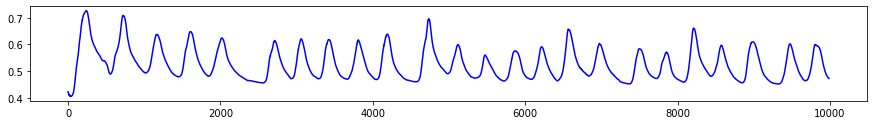

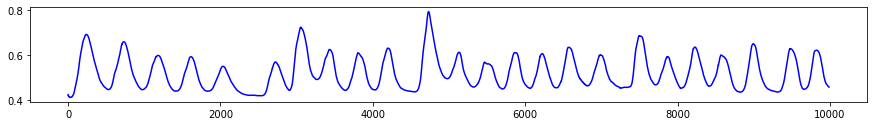

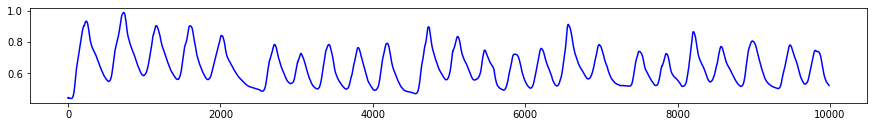

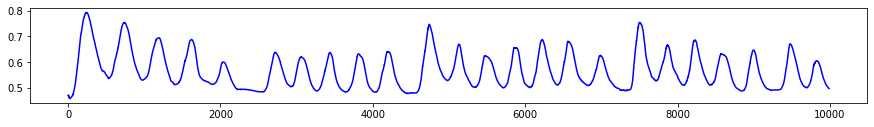

In [24]:
x = range(0, len(df_test))
fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,1)
plt.plot(x, df_test['1'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,2)
plt.plot(x, df_test['2'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,3)
plt.plot(x, df_test['3'], 'b')
plt.show()

fig = plt.figure(figsize = (15, 8))
plt.subplot(4,1,4)
plt.plot(x, df_test['4'], 'b')
plt.show()

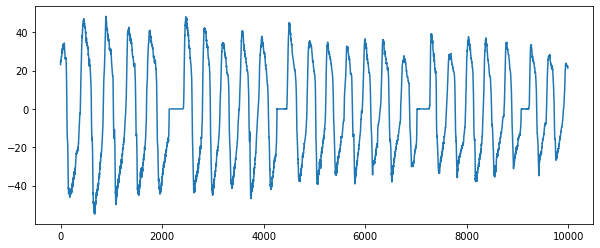

In [25]:
fig = plt.figure(figsize = (10, 4))
plt.plot(flow_test['Flow'])

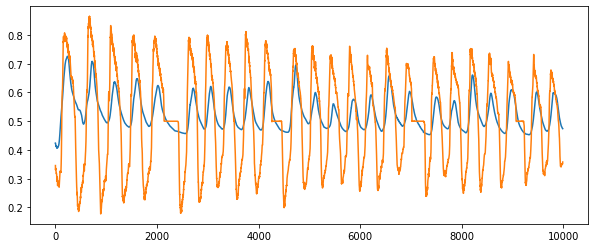

In [26]:
flow_test['a'] = (flow_test['Flow'] / 150) - 0.5
fig = plt.figure(figsize = (10, 4))
plt.plot(x, df_test['1'], x, flow_test['a']*-1)

In [27]:
flow_test.drop('a', inplace = True, axis = 1)

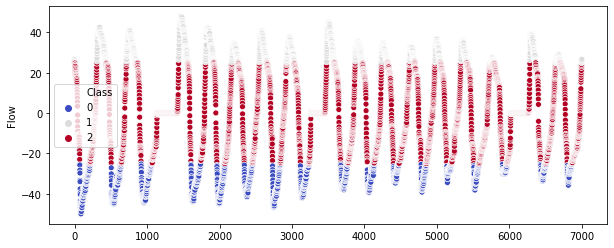

In [28]:
fig = plt.figure(figsize = (10, 4))
sns.scatterplot(y = flow_test['Flow'][1000:8000], x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

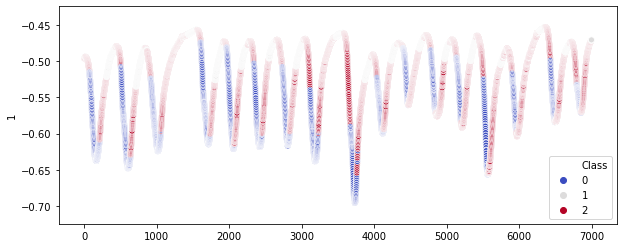

In [29]:
fig = plt.figure(figsize = (10, 4))
sns.scatterplot(y = df_test['1'][1000:8000]*-1, x = range(0, 7000), hue = df_test['Class'][1000:8000], palette = 'coolwarm')

In [30]:
test_sensors = df_test.drop('Class', axis = 1)
test_sensors.drop('hours', inplace = True, axis = 1)
test_sensors.drop('minutes', inplace = True, axis = 1)
test_sensors.drop('seconds', inplace = True, axis = 1)

# Create the classification matrix
test_class = df_test['Class']
test_class = pd.DataFrame(test_class, index = None, columns = ['Class'])

#### model testing - random forest

In [31]:
test_predictions = rf_model.predict(test_sensors)
print(" accuracy = ", accuracy_score(test_class, test_predictions))
print(confusion_matrix(test_class, test_predictions))
print("\n")

print('Random Forest - Testing')
print('\n')
print(classification_report(test_class, test_predictions))

 accuracy =  0.7191911102212434
[[1776    0  423]
 [  19  996 1217]
 [ 478  668 4412]]


Random Forest - Testing


              precision    recall  f1-score   support

           0       0.78      0.81      0.79      2199
           1       0.60      0.45      0.51      2232
           2       0.73      0.79      0.76      5558

    accuracy                           0.72      9989
   macro avg       0.70      0.68      0.69      9989
weighted avg       0.71      0.72      0.71      9989



In [32]:
testPredictions = classSwitch(test_predictions)
testClass = classSwitch(list(test_class['Class']))
print('Random Forest - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Random Forest - Testing


              precision    recall  f1-score   support

           0       0.87      0.76      0.81      5862
           1       0.71      0.84      0.77      4126
           2       0.12      1.00      0.22         1

    accuracy                           0.79      9989
   macro avg       0.57      0.87      0.60      9989
weighted avg       0.81      0.79      0.79      9989



### model testing - deep learning

In [33]:
test_predictions = model.predict(test_sensors)

final_pred_test = []
for score in range(0, len(test_predictions)):
    final_pred_test.append(np.argmax(test_predictions[score]))

print('Keras Model - Testing')
print('\n')
print(classification_report(test_class, final_pred_test))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.80      0.73      0.76      2199
           1       0.56      0.46      0.50      2232
           2       0.71      0.78      0.74      5558

    accuracy                           0.70      9989
   macro avg       0.69      0.66      0.67      9989
weighted avg       0.69      0.70      0.69      9989



In [34]:
testPredictions = classSwitch(final_pred_test)
testClass = classSwitch(list(test_class['Class']))
print('Keras Model - Testing')
print('\n')
print(classification_report(testClass, testPredictions))

Keras Model - Testing


              precision    recall  f1-score   support

           0       0.88      0.77      0.82      5862
           1       0.72      0.82      0.77      4126
           2       0.01      1.00      0.02         1

    accuracy                           0.79      9989
   macro avg       0.53      0.86      0.54      9989
weighted avg       0.81      0.79      0.80      9989



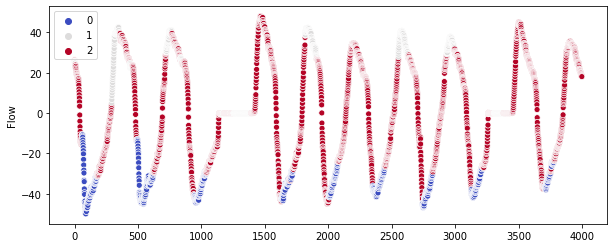

In [35]:
fig = plt.figure(figsize = (10, 4))
sns.scatterplot(y = flow_test['Flow'][1000:5000], x = range(0, 4000), hue = final_pred_test[1000:5000], palette = 'coolwarm')

#### Save TFLite Model

keras_file = "model_4.h5"
keras.models.save_model(model, keras_file)
converter = tf.lite.TocoConverter.from_keras_model_file('model_4.h5')
tflite_model = converter.convert()
open("model_4.tflite", "wb").write(tflite_model)